In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


X_train = pd.read_csv("/content/drive/MyDrive/diamond-price-prediciton-2024/train.csv")
X_train.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Eploration

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [20]:
X_train.drop("Id", axis=1, inplace=True)

In [21]:
X_train.describe()

,carat,depth,table,price,x,y,z
count,43111.000000,43111.000000,43111.000000,43111.000000,43111.000000,43111.000000,43111.000000
mean,0.796168,61.747176,57.456494,3922.455267,5.729780,5.731347,3.536599
std,0.469282,1.420891,2.223861,3977.069761,1.116026,1.108183,0.691296
min,0.200000,50.800000,43.000000,326.000000,3.730000,3.680000,0.000000
25%,0.400000,61.000000,56.000000,947.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2400.000000,5.700000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,5302.000000,6.540000,6.540000,4.030000
max,2.800000,72.200000,79.000000,18823.000000,9.170000,9.130000,6.160000


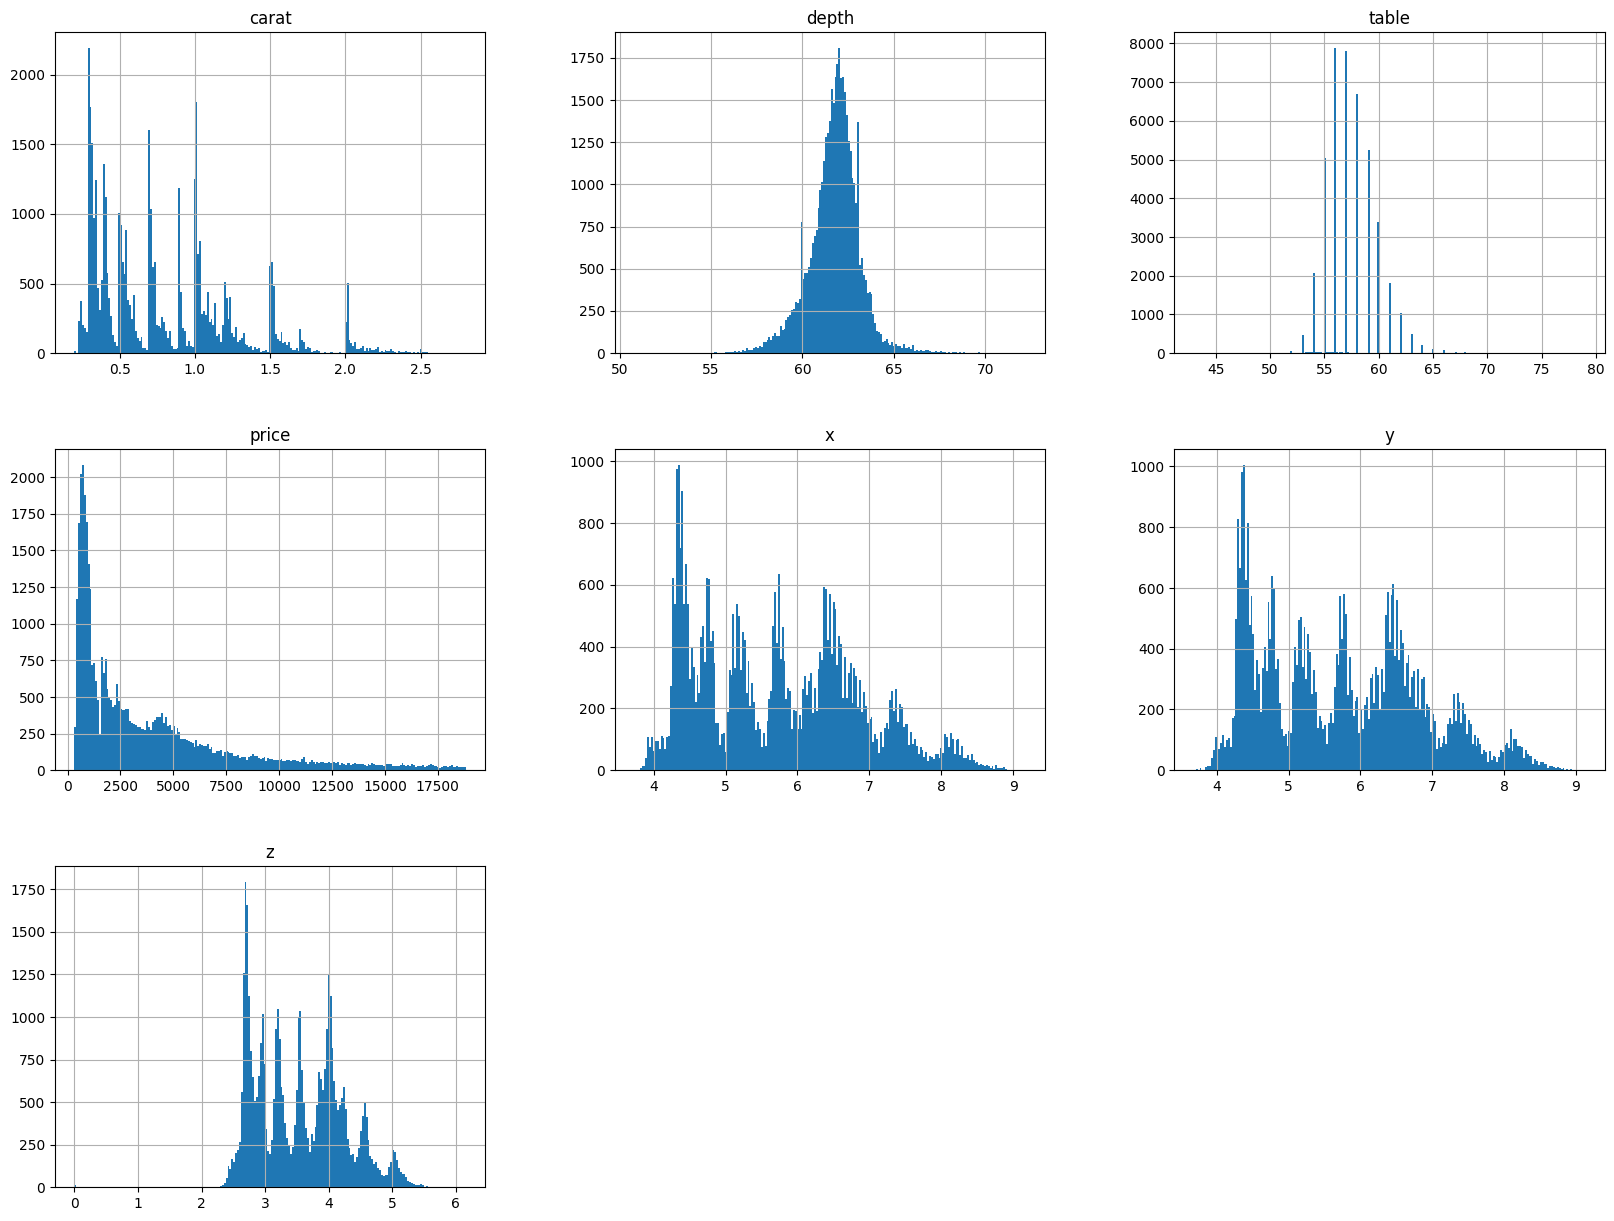

In [22]:
X_train.hist(bins=int(X_train.shape[0] ** 0.5), figsize=(20, 15))
plt.show()

In [23]:
num_atts = ["carat", "depth", "z", "x", "y", "price", "table"]
cat_atts = ["cut", "color", "clarity"]

num_corr = X_train[num_atts].corr().price
cat_corr = pd.Series([X_train["price"].corr(X_train[cat], method="spearman") for cat in cat_atts], index=cat_atts)

price_corr = pd.concat([num_corr, cat_corr]).sort_values(ascending=False)
price_corr

price      1.000000
carat      0.923859
y          0.888609
x          0.886908
z          0.876410
color      0.147505
table      0.127483
cut        0.041996
depth     -0.013895
clarity   -0.113177
dtype: float64

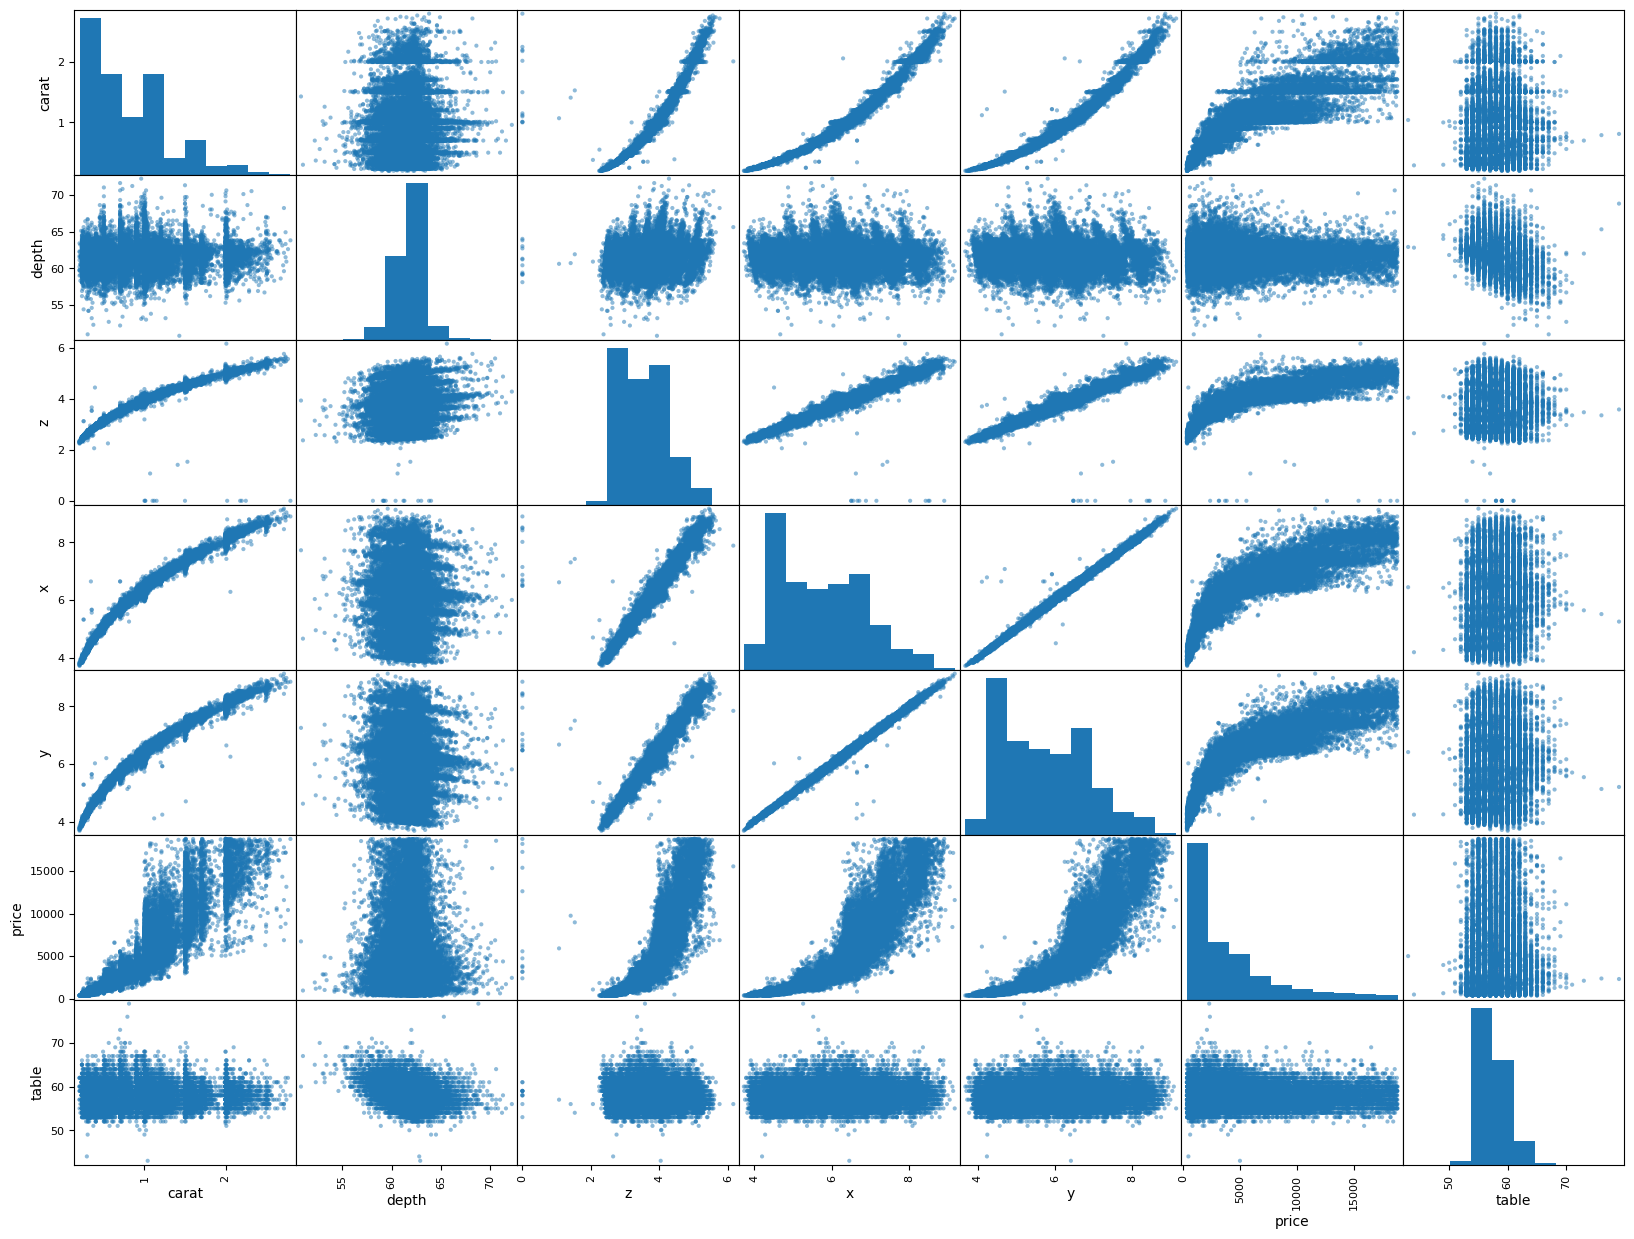

In [24]:
from pandas.plotting import scatter_matrix


scatter_matrix(X_train[num_atts], figsize=(20, 15))
plt.show()

In [6]:
qes = X_train.price.quantile([0.25, 0.75])
iqr = qes.iloc[0] - qes.iloc[0]

ILF = qes.iloc[0] - 1.5 * iqr
OLF = qes.iloc[0] - 1.5 * 1.5 * iqr
IUF = qes.iloc[1] + 1.5 * iqr
OUF = qes.iloc[1] + 1.5 * 1.5 * iqr

In [7]:
X_train.price.between(OLF, X_train.price.min()).sum()

0

In [8]:
X_train.price.between(OUF, X_train.price.max()).sum() # !!!!!!!!!

10789

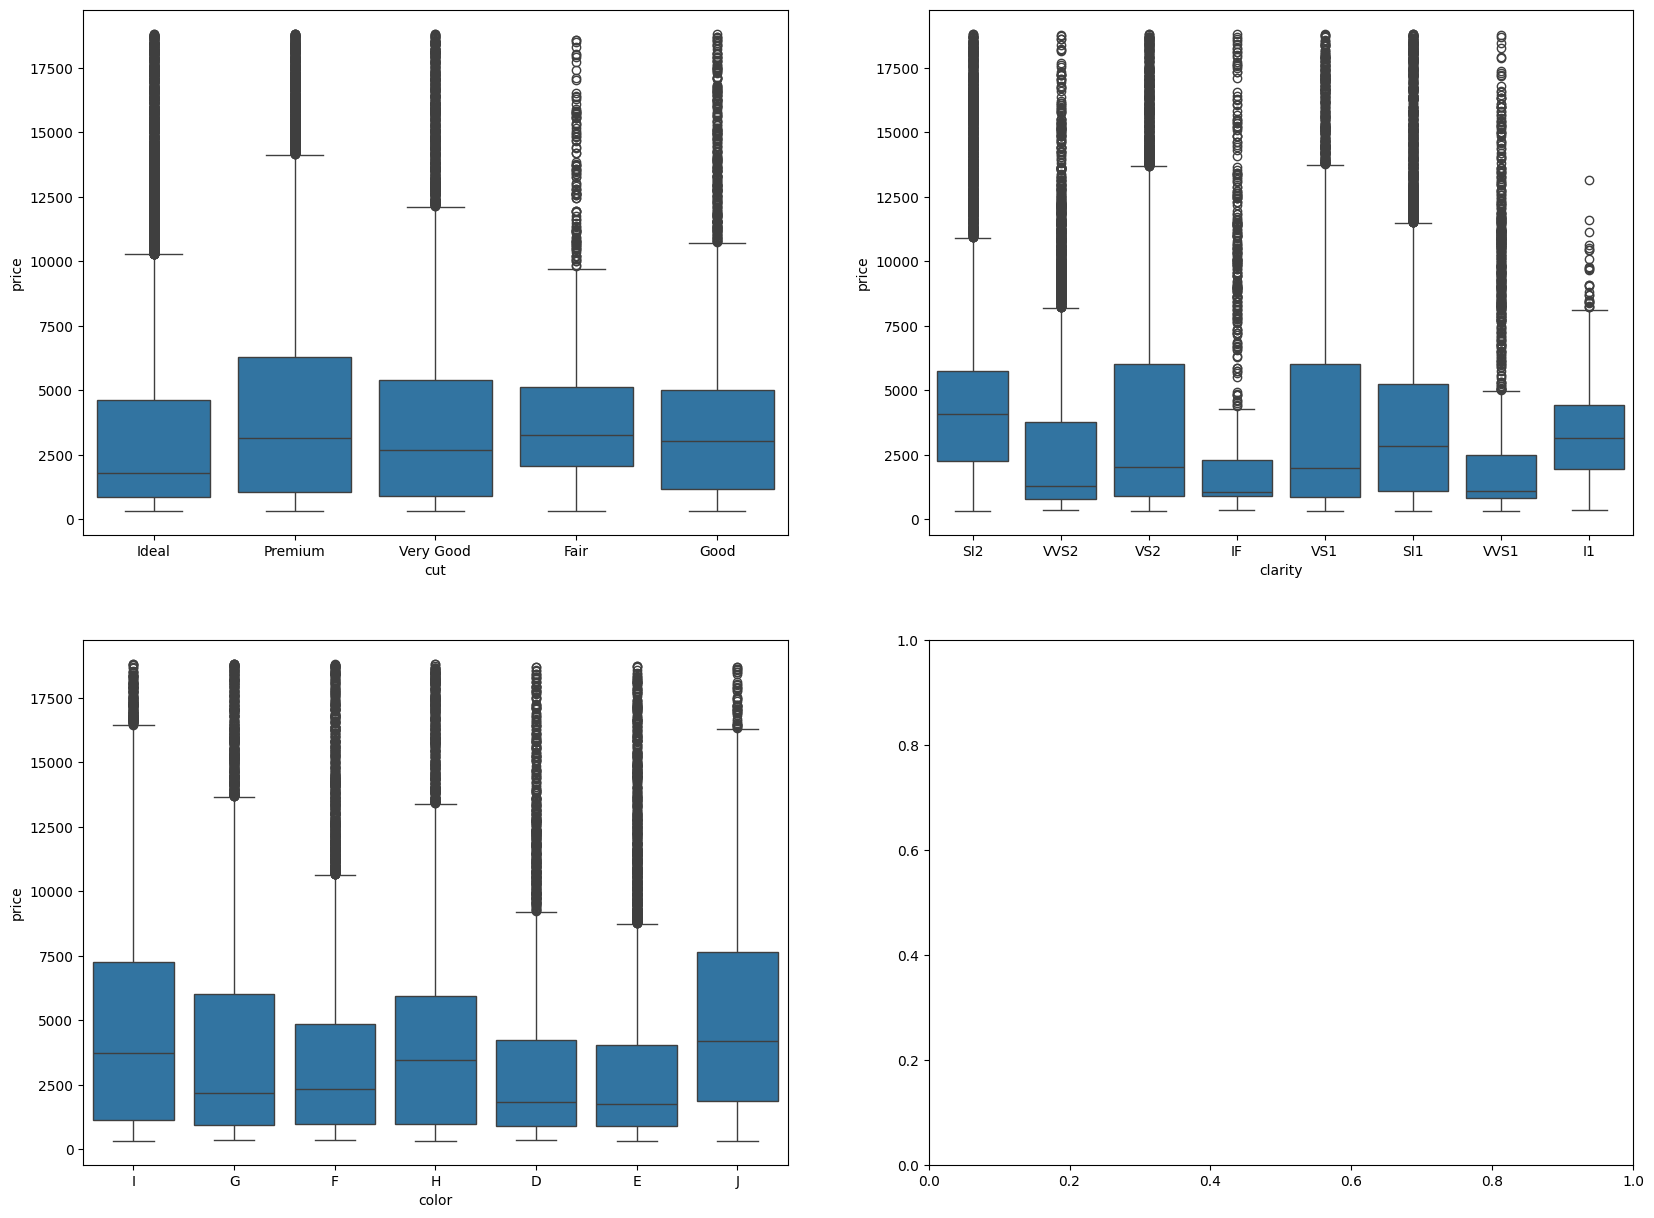

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
sns.boxplot(data=X_train, y="price", x="cut", ax=axes[0, 0])
sns.boxplot(data=X_train, y="price", x="clarity", ax=axes[0, 1])
sns.boxplot(data=X_train, y="price", x="color", ax=axes[1, 0])
plt.show()

<Axes: xlabel='x', ylabel='price'>

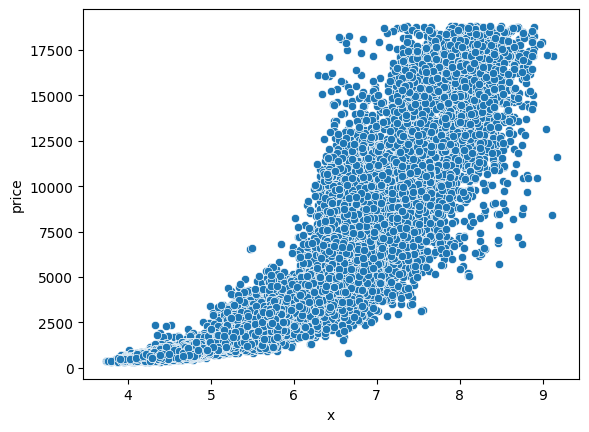

In [26]:
sns.scatterplot(x=X_train["x"], y = X_train["price"])

In [9]:
X_train[X_train["x"] < 2 ].shape

(5, 11)

<Axes: xlabel='y', ylabel='price'>

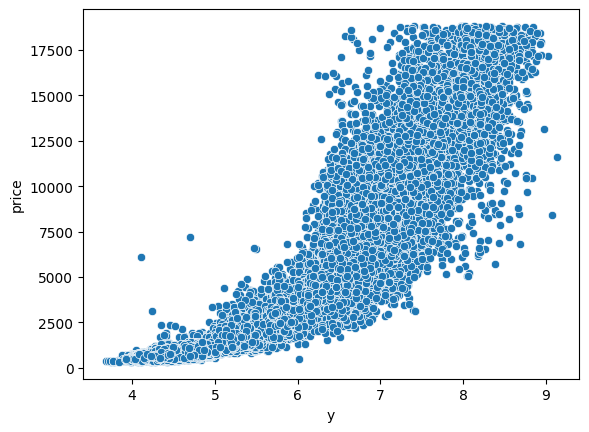

In [27]:
sns.scatterplot(x=X_train["y"], y = X_train["price"])

In [28]:
X_train[X_train["y"] > 30 ].shape

(0, 10)

<Axes: xlabel='z', ylabel='price'>

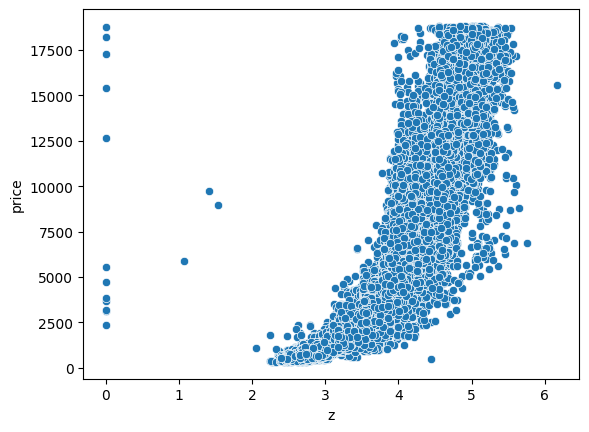

In [29]:
sns.scatterplot(x=X_train["z"], y = X_train["price"])

In [30]:
X_train[X_train["z"] > 30 ].shape

(0, 10)

<Axes: xlabel='depth', ylabel='price'>

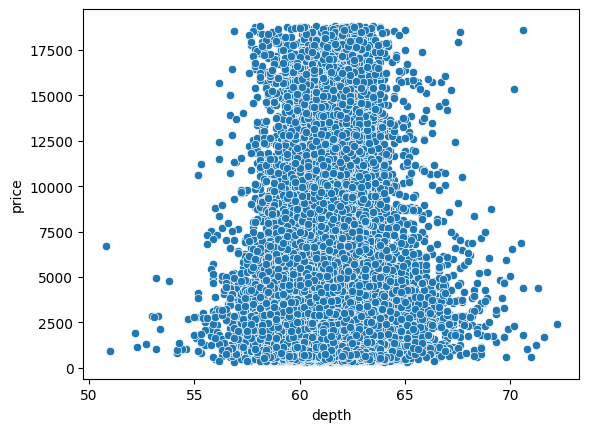

In [31]:
sns.scatterplot(x= X_train["depth"] , y=X_train["price"])

In [32]:
X_train[(X_train["depth"] > 75) | (X_train["depth"] < 45 )].shape

(0, 10)

<Axes: xlabel='table', ylabel='price'>

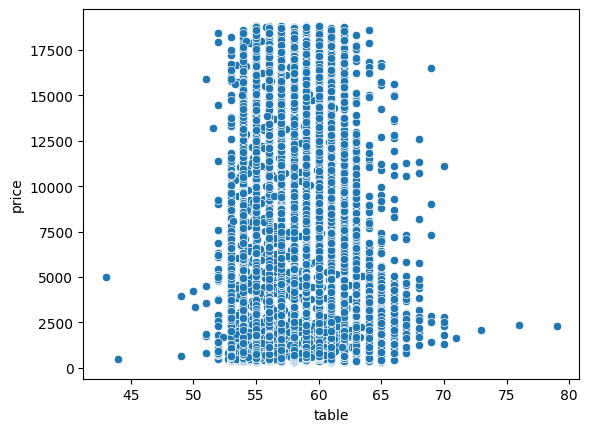

In [33]:
sns.scatterplot(x= X_train["table"] , y=X_train["price"])

In [34]:
X_train[X_train["table"] > 90].shape

(0, 10)

# Data Pre-processing

In [10]:
cut_map = {
    "Fair":1, "Good":2, "Very Good":3, "Premium":4, "Ideal":5
}

color_map = {
    'D': 7, 'E':6, 'F':5, 'G':4, 'H':3, 'I':2, 'J':1
}
clarity_map = {
    "I1": 1, "SI2": 2, "SI1": 3, "VS2": 4, "VS1": 5, "VVS2": 6, "VVS1": 7, "IF": 8
}

In [11]:
tmp = X_train.copy()

In [12]:
tmp.cut = tmp.cut.map(cut_map)
tmp.clarity = tmp.clarity.map(clarity_map)
tmp.color = tmp.color.map(color_map)

<Axes: xlabel='x', ylabel='price'>

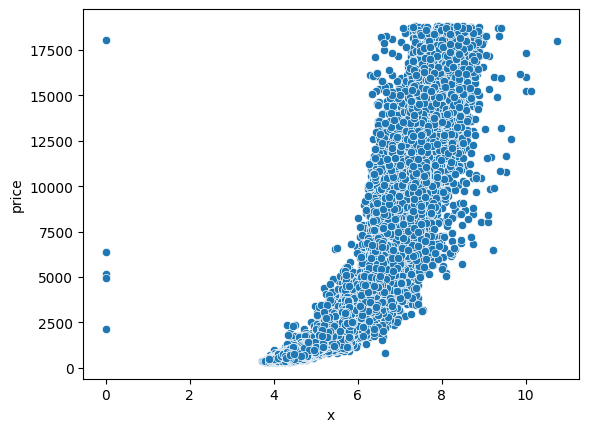

In [13]:
sns.scatterplot(x=X_train["x"], y = X_train["price"])

In [14]:
carat_index = list(X_train[X_train["carat"] >= 3].index)
x_index = list(X_train[X_train["x"] < 2 ].index)
y_index = list(X_train[X_train["y"] > 30 ].index)
z_index = list(X_train[X_train["z"] > 30 ].index)
depth_index = list(X_train[(X_train["depth"] > 75) | (X_train["depth"] < 45 )].index)
table_index = list(X_train[X_train["table"] > 90].index)

indexes = carat_index + x_index + y_index + z_index + depth_index + table_index
len(indexes)

41

In [15]:
print("DataFrame shape before delete outliers is. ", X_train.shape)
for outlier in indexes:
    X_train.drop(outlier, inplace=True)
print("DataFrame shape after deleting outliers. ",X_train.shape)

DataFrame shape before delete outliers is.  (43152, 11)
DataFrame shape after deleting outliers.  (43111, 11)


<Axes: xlabel='x', ylabel='price'>

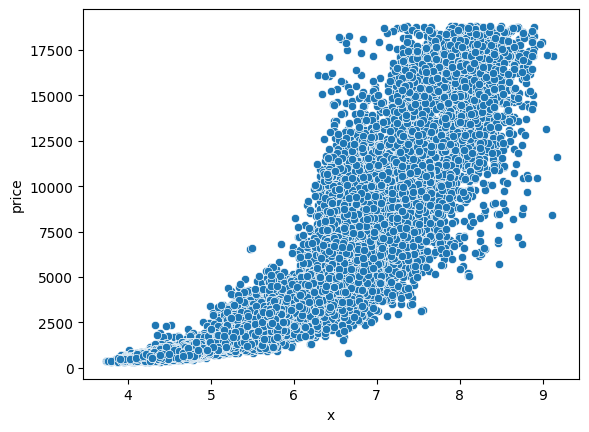

In [16]:
sns.scatterplot(x=X_train["x"], y = X_train["price"])

In [52]:
tmp["volume"] = tmp.x * tmp.y * tmp.z
tmp["density"] = tmp.carat / tmp.volume
tmp["surface_area"] = 2 * (tmp.x * tmp.y + tmp.y * tmp.z + tmp.x * tmp.z)
tmp["length_to_width_ratio"] = tmp.x / tmp.y
tmp["symmetry_score"] = np.abs(tmp.x - tmp.y) + np.abs(tmp.x - tmp.z) + np.abs(tmp.y - tmp.z)
tmp["depth_percentage"] = (tmp.depth / ((tmp.x + tmp.y + tmp.z) / 3)) * 100
tmp["table_percentage"] = (tmp.table / (tmp.x + tmp.y) / 2) * 100
tmp["Hypotenuse"] = ((tmp.table**2) * ((tmp.x + tmp.y) / 2)**2 )**0.5

In [53]:
tmp.dropna(inplace=True)
tmp.replace(np.inf, 1, inplace=True)
tmp.corr().price.sort_values(ascending=False)

price                    1.000000
carat                    0.921894
surface_area             0.899373
volume                   0.898307
x                        0.886866
y                        0.862947
z                        0.859255
Hypotenuse               0.858579
symmetry_score           0.723084
table                    0.128465
length_to_width_ratio    0.067324
density                  0.022478
Id                      -0.001123
depth                   -0.013149
cut                     -0.056402
clarity                 -0.147520
color                   -0.171811
table_percentage        -0.811587
depth_percentage        -0.816444
Name: price, dtype: float64

In [47]:
tmp.to_csv('file1.csv')

In [50]:
predictors, tar = tmp.drop("price", axis=1), tmp.price.copy()

In [37]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
prepared = scaler.fit_transform(predictors)

In [55]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


lm = RandomForestRegressor()
lm.fit(prepared, tar)
mean_squared_error(tar, lm.predict(prepared)) ** 0.5

201.55698082045814

In [ ]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(
    RandomForestRegressor(),
    prepared,
    tar,
    scoring="neg_mean_squared_error",
    cv=10
)

((-scores) ** 0.5).mean()

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

lm = ExtraTreesRegressor()
lm.fit(prepared, tar)
mean_squared_error(tar, lm.predict(prepared)) ** 0.5

0.3283586711063132

In [ ]:
scores = cross_val_score(
    ExtraTreesRegressor(),
    prepared,
    tar,
    scoring="neg_mean_squared_error",
    cv=10
)

((-scores) ** 0.5).mean()

530.932440137321

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


lm = GradientBoostingRegressor()
lm.fit(prepared, tar)
mean_squared_error(tar, lm.predict(prepared)) ** 0.5

591.1154086365491

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


lm = KNeighborsRegressor()
lm.fit(prepared, tar)
mean_squared_error(tar, lm.predict(prepared)) ** 0.5

625.3459217115294

In [ ]:
scores = cross_val_score(
    KNeighborsRegressor(n_neighbors=13),
    prepared,
    tar,
    scoring="neg_mean_squared_error",
    cv=10
)

((-scores) ** 0.5).mean()

767.2842186897302

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


lm = GradientBoostingRegressor()
lm.fit(prepared, tar)
mean_squared_error(tar, lm.predict(prepared)) ** 0.5

591.1154086365492

In [ ]:
scores = cross_val_score(
    GradientBoostingRegressor(),
    prepared,
    tar,
    scoring="neg_mean_squared_error",
    cv=10
)

((-scores) ** 0.5).mean()

616.8175674889856

In [51]:
from sklearn.model_selection import GridSearchCV
param_grid = [
              {'n_estimators': [3,10,30], 'max_features':[8,10,12]},
              {'bootstrap':[False], 'max_features':[2,3,4],'n_estimators':[3,10]}
]
forest_reg = RandomForestRegressor(random_state = 42)

grid_search = GridSearchCV(forest_reg,param_grid,cv = 5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score = True)
grid_search.fit(prepared,tar)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [8, 10, 12],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [52]:
# CODE HERE
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
  print(np.sqrt(-mean_score), params)

660.3775740298254 {'max_features': 8, 'n_estimators': 3}
579.803781879605 {'max_features': 8, 'n_estimators': 10}
557.7986338016104 {'max_features': 8, 'n_estimators': 30}
647.0060744309686 {'max_features': 10, 'n_estimators': 3}
578.7396143333565 {'max_features': 10, 'n_estimators': 10}
556.1910922394048 {'max_features': 10, 'n_estimators': 30}
646.5416348257082 {'max_features': 12, 'n_estimators': 3}
574.8065543118131 {'max_features': 12, 'n_estimators': 10}
556.020763569486 {'max_features': 12, 'n_estimators': 30}
907.2407863771532 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
762.1921105980842 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
782.2689859207624 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
675.0991674591576 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
703.3682225670822 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
622.3025340067732 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
